In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations 
from collections import defaultdict
from scipy import stats

In [81]:
INPUT_FILE = "data/consistency_analysis.csv"

**DATA DICTIONARY**
|Feature|Type|Description|
| --- | --- | --- |
|Contract|string|Contract identifier (e.g., "2023-03660-000")|
|Difficulty|string|Contract complexity: "Easy", "Medium", or "Hard"|
|Service_Raw|string|Role or service title (e.g., "Mechanic", "Police")|
|Coder|string|Coder: "W", "G", or "D"|
|Round|int|Exercise number: 1 (employees) or 2 (services)|
|NAICS_Raw|string|Assigned NAICS code, semicolon-delimited if multiple|

In [82]:
def load_data(filepath):
    """
    Loads data into pandas
    
    :param filepath: filepath of xlsx
    """
    df = pd.read_csv(filepath)
    return df

df = load_data(INPUT_FILE)

In [83]:
def eda(df):
    """
    Performs exploratory data analysis
    
    :param df: pandas dataframe for EDA
    """

    print("=" * 60)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 60)

    print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")

    print(f"\nColumns: {df.columns.tolist()}")

    print(f"\nData types:\n{df.dtypes}")

    print(f"\nUnique contracts: {df['Contract'].nunique()}")
    print(f"Unique coders: {df['Coder'].unique().tolist()}")
    print(f"Rounds: {df['Round'].unique().tolist()}")
    print(f"Difficulty levels: {df['Difficulty'].unique().tolist()}")

    print(f"\nMissing values:\n{df.isnull().sum()}")

    print(f"\nFirst 10 rows:\n{df.head(10).to_string()}")

eda(df)

EXPLORATORY DATA ANALYSIS

Shape: 272 rows × 6 columns

Columns: ['Contract', 'Difficulty', 'Service_Raw', 'Coder', 'Round', 'NAICS_Raw']

Data types:
Contract       object
Difficulty     object
Service_Raw    object
Coder          object
Round           int64
NAICS_Raw      object
dtype: object

Unique contracts: 11
Unique coders: ['W', 'G', 'D']
Rounds: [1, 2]
Difficulty levels: ['Easy', 'Medium', 'Hard']

Missing values:
Contract       0
Difficulty     0
Service_Raw    0
Coder          0
Round          0
NAICS_Raw      3
dtype: int64

First 10 rows:
         Contract Difficulty                              Service_Raw Coder  Round NAICS_Raw
0  2023-03660-000       Easy                                 Mechanic     W      1    237310
1  2023-03660-000       Easy                             Truck driver     W      1    237310
2  2023-03660-000       Easy                 Heavy equipment operator     W      1    237310
3  2023-03660-000       Easy                           Service person

In [84]:
def clean(df):
    """
    Clean dataframe
    
    :param df: pandas dataframe for cleaning
    """
    df_clean = df.copy()

    df_clean['Contract'] = df_clean['Contract'].str.strip()

    df_clean['has_naics'] = df_clean['NAICS_Raw'].notna() & (df_clean['NAICS_Raw'] != '')

    df_clean['is_multicode'] = df_clean['NAICS_Raw'].str.contains(';', na=False)

    df_clean['lookup_key'] = df_clean['Contract'] + '|' + df_clean['Service_Raw']

    print(f"Cleaned data: {len(df_clean)} rows (from {len(df)} original)")
    print(f"Rows with valid NAICS: {df_clean['has_naics'].sum()}")
    print(f"Multi-code entries: {df_clean['is_multicode'].sum()}")
    
    return df_clean

df = clean(df)

Cleaned data: 272 rows (from 272 original)
Rows with valid NAICS: 269
Multi-code entries: 8


In [85]:
def eda(df):
    """
    Performs exploratory data analysis
    
    :param df: pandas dataframe for EDA
    """

    print("=" * 60)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 60)

    print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")

    print(f"\nColumns: {df.columns.tolist()}")

    print(f"\nData types:\n{df.dtypes}")

    print(f"\nUnique contracts: {df['Contract'].nunique()}")
    print(f"Unique coders: {df['Coder'].unique().tolist()}")
    print(f"Rounds: {df['Round'].unique().tolist()}")
    print(f"Difficulty levels: {df['Difficulty'].unique().tolist()}")

    print(f"\nMissing values:\n{df.isnull().sum()}")

    print(f"\nFirst 10 rows:\n{df.head(10).to_string()}")

eda(df)

EXPLORATORY DATA ANALYSIS

Shape: 272 rows × 9 columns

Columns: ['Contract', 'Difficulty', 'Service_Raw', 'Coder', 'Round', 'NAICS_Raw', 'has_naics', 'is_multicode', 'lookup_key']

Data types:
Contract        object
Difficulty      object
Service_Raw     object
Coder           object
Round            int64
NAICS_Raw       object
has_naics         bool
is_multicode      bool
lookup_key      object
dtype: object

Unique contracts: 10
Unique coders: ['W', 'G', 'D']
Rounds: [1, 2]
Difficulty levels: ['Easy', 'Medium', 'Hard']

Missing values:
Contract        0
Difficulty      0
Service_Raw     0
Coder           0
Round           0
NAICS_Raw       3
has_naics       0
is_multicode    0
lookup_key      0
dtype: int64

First 10 rows:
         Contract Difficulty                              Service_Raw Coder  Round NAICS_Raw  has_naics  is_multicode                                              lookup_key
0  2023-03660-000       Easy                                 Mechanic     W      1    237

In [86]:
def get_codes(naics_value):
    """
    Flexible parsing for NAICS code string to convert to set depending on number of values
    
    :param naics_value: NAICS string from a given row
    """

    if pd.isna(naics_value) or naics_value == "":
        return set()
    
    codes = str(naics_value).split(';')
    return set(code.strip() for code in codes if code.strip())

In [87]:
df['prefix'] = df['NAICS_Raw'].astype(str).str[:2]

In [88]:
print(df.head())

         Contract Difficulty               Service_Raw Coder  Round NAICS_Raw  \
0  2023-03660-000       Easy                  Mechanic     W      1    237310   
1  2023-03660-000       Easy              Truck driver     W      1    237310   
2  2023-03660-000       Easy  Heavy equipment operator     W      1    237310   
3  2023-03660-000       Easy            Service person     G      1    237310   
4  2023-03660-000       Easy              Truck driver     G      1    237310   

   has_naics  is_multicode                               lookup_key prefix  
0       True         False                  2023-03660-000|Mechanic     23  
1       True         False              2023-03660-000|Truck driver     23  
2       True         False  2023-03660-000|Heavy equipment operator     23  
3       True         False            2023-03660-000|Service person     23  
4       True         False              2023-03660-000|Truck driver     23  


In [89]:
out = (
    df
    .groupby(['Coder', 'prefix'])
    .size()
    .rename('n')
    .reset_index()
    .assign(
        pct=lambda x: x['n'] / x.groupby('Coder')['n'].transform('sum') * 100,
        rank=lambda x: x.groupby('Coder')['n'].rank(method='first', ascending=False)
    )
    .query('rank <= 10')
    .pivot(index='Coder', columns='rank', values=['prefix', 'pct'])
)

out.columns = [f'{a}_{int(b)}' for a, b in out.columns]
out = out.reset_index()
out

,Coder,prefix_1,prefix_2,prefix_3,prefix_4,prefix_5,prefix_6,prefix_7,prefix_8,prefix_9,...,pct_1,pct_2,pct_3,pct_4,pct_5,pct_6,pct_7,pct_8,pct_9,pct_10
0,D,23,92,56,22,54,71,81,na,48,...,33.333333,27.927928,18.018018,5.405405,4.504505,3.603604,2.702703,2.702703,0.900901,0.900901
1,G,23,92,56,54,22,81,48,71,11,...,41.176471,23.529412,11.764706,7.058824,5.882353,3.529412,2.352941,2.352941,1.176471,1.176471
2,W,23,92,54,56,81,22,71,21,48,...,30.263158,30.263158,11.842105,11.842105,5.263158,3.947368,2.631579,1.315789,1.315789,1.315789


In [90]:
print(out)

  Coder prefix_1 prefix_2 prefix_3 prefix_4 prefix_5 prefix_6 prefix_7  \
0     D       23       92       56       22       54       71       81   
1     G       23       92       56       54       22       81       48   
2     W       23       92       54       56       81       22       71   

  prefix_8 prefix_9  ...      pct_1      pct_2      pct_3      pct_4  \
0       na       48  ...  33.333333  27.927928  18.018018   5.405405   
1       71       11  ...  41.176471  23.529412  11.764706   7.058824   
2       21       48  ...  30.263158  30.263158  11.842105  11.842105   

      pct_5     pct_6     pct_7     pct_8     pct_9    pct_10  
0  4.504505  3.603604  2.702703  2.702703  0.900901  0.900901  
1  5.882353  3.529412  2.352941  2.352941  1.176471  1.176471  
2  5.263158  3.947368  2.631579  1.315789  1.315789  1.315789  

[3 rows x 21 columns]


In [91]:
prefix_cols = [c for c in out.columns if c.startswith('prefix_')]

coder_prefix_sets = (
    out
    .set_index('Coder')[prefix_cols]
    .apply(lambda row: set(row.dropna()), axis=1)
)

In [92]:
shared_prefixes = set.intersection(*coder_prefix_sets)

shared_prefixes

{'22', '23', '48', '54', '56', '71', '81', '92'}

In [93]:
shared_prefix_means = {}

for p in shared_prefixes:
    pct_vals = []
    for i in range(1, 11):  # adjust max rank if needed
        mask = out[f'prefix_{i}'] == p
        pct_vals.extend(out.loc[mask, f'pct_{i}'].tolist())
    shared_prefix_means[p] = sum(pct_vals) / len(pct_vals)

In [94]:
top_shared = (
    pd.Series(shared_prefix_means)
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

top_shared

['23', '92', '56', '54', '22']

In [95]:
rows = []

for _, row in out.iterrows():
    coder = row['Coder']
    record = {'Coder': coder}

    for p in top_shared:
        for i in range(1, 11):
            if row[f'prefix_{i}'] == p:
                record[p] = row[f'pct_{i}']
                break
        else:
            record[p] = 0.0  # prefix not used by this coder

    rows.append(record)

comparison = pd.DataFrame(rows)

In [96]:
comparison

,Coder,23,92,56,54,22
0,D,33.333333,27.927928,18.018018,4.504505,5.405405
1,G,41.176471,23.529412,11.764706,7.058824,5.882353
2,W,30.263158,30.263158,11.842105,11.842105,3.947368


In [97]:
r2 = df[df['Round'] == 2]

In [98]:
df.columns

Index(['Contract', 'Difficulty', 'Service_Raw', 'Coder', 'Round', 'NAICS_Raw',
       'has_naics', 'is_multicode', 'lookup_key', 'prefix'],
      dtype='object')

In [99]:
# ---------------------------
# 1️⃣ Build pairwise disagreement per contract
# ---------------------------

# Group coder → NAICS sets, keeping Round & Difficulty
sets = (
    df
    .groupby(['Contract', 'Round', 'Difficulty', 'Coder'])['NAICS_Raw']
    .apply(lambda x: set(x.dropna()))
    .reset_index()
)

rows = []

for (contract, round_, difficulty), g in sets.groupby(['Contract', 'Round', 'Difficulty']):
    coder_sets = dict(zip(g['Coder'], g['NAICS_Raw']))
    
    # Compute pairwise Jaccard distances
    dists = [
        1 - len(coder_sets[c1] & coder_sets[c2]) / len(coder_sets[c1] | coder_sets[c2])
        for c1, c2 in combinations(coder_sets, 2)
    ]
    
    rows.append({
        'Contract': contract,
        'Round': round_,
        'Difficulty': difficulty,
        'mean_disagreement': sum(dists) / len(dists) if dists else 0.0,
        'max_disagreement': max(dists) if dists else 0.0,
        'n_coders': len(coder_sets)
    })

disagreement_by_contract = pd.DataFrame(rows)

In [100]:
# ---------------------------
# 2️⃣ Aggregate by Round
# ---------------------------

disagreement_by_round = (
    disagreement_by_contract
    .groupby('Round')
    .agg({
        'mean_disagreement': 'mean',
        'max_disagreement': 'mean',
        'n_coders': 'mean'
    })
    .reset_index()
)

# ---------------------------
# 3️⃣ Aggregate by Difficulty
# ---------------------------

disagreement_by_difficulty = (
    disagreement_by_contract
    .groupby('Difficulty')
    .agg({
        'mean_disagreement': 'mean',
        'max_disagreement': 'mean',
        'n_coders': 'mean'
    })
    .reset_index()
)


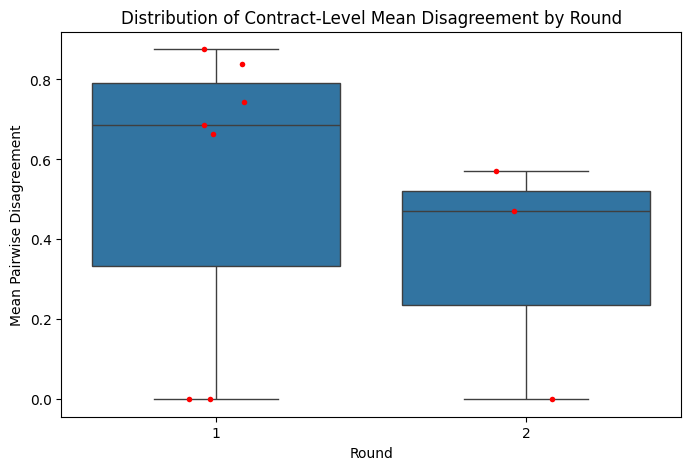

In [101]:
# ---------------------------
# 4️⃣ Visualization: mean disagreement by Round
# ---------------------------

plt.figure(figsize=(8,5))
sns.boxplot(data=disagreement_by_contract, x='Round', y='mean_disagreement')
sns.stripplot(data=disagreement_by_contract, x='Round', y='mean_disagreement', color='red', size=4, jitter=True)
plt.title("Distribution of Contract-Level Mean Disagreement by Round")
plt.ylabel("Mean Pairwise Disagreement")
plt.show()

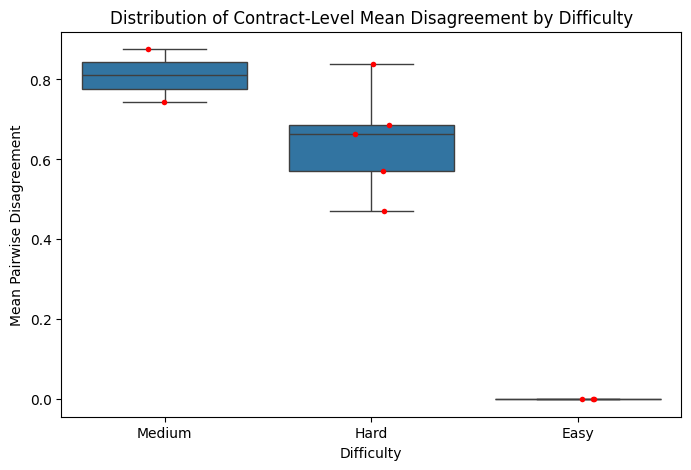

In [102]:
# ---------------------------
# 5️⃣ Visualization: mean disagreement by Difficulty
# ---------------------------

plt.figure(figsize=(8,5))
sns.boxplot(data=disagreement_by_contract, x='Difficulty', y='mean_disagreement')
sns.stripplot(data=disagreement_by_contract, x='Difficulty', y='mean_disagreement', color='red', size=4, jitter=True)
plt.title("Distribution of Contract-Level Mean Disagreement by Difficulty")
plt.ylabel("Mean Pairwise Disagreement")
plt.show()

In [103]:

# ---------------------------
# 6️⃣ Quick Analysis
# ---------------------------

print("Mean disagreement by Round:")
print(disagreement_by_round)

print("\nMean disagreement by Difficulty:")
print(disagreement_by_difficulty)

# Optional: contracts with highest disagreement
top_disagreements = disagreement_by_contract.sort_values('mean_disagreement', ascending=False).head(10)
print("\nTop 10 most disagreed contracts:")
print(top_disagreements[['Contract', 'Round', 'Difficulty', 'mean_disagreement', 'max_disagreement']])

Mean disagreement by Round:
   Round  mean_disagreement  max_disagreement  n_coders
0      1           0.544224          0.612745       3.0
1      2           0.347536          0.380952       3.0

Mean disagreement by Difficulty:
  Difficulty  mean_disagreement  max_disagreement  n_coders
0       Easy           0.000000          0.000000       3.0
1       Hard           0.646420          0.731513       3.0
2     Medium           0.810037          0.887255       3.0

Top 10 most disagreed contracts:
         Contract  Round Difficulty  mean_disagreement  max_disagreement
5  2025-00926-000      1     Medium           0.875630          0.941176
6  2025-03419-000      1       Hard           0.838889          1.000000
0  2019-04459-000      1     Medium           0.744444          0.833333
7  2025-03668-000      1       Hard           0.685897          0.750000
1  2023-01776-000      1       Hard           0.664706          0.764706
4  2024-04451-000      2       Hard           0.570929    

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Contract      272 non-null    object
 1   Difficulty    272 non-null    object
 2   Service_Raw   272 non-null    object
 3   Coder         272 non-null    object
 4   Round         272 non-null    int64 
 5   NAICS_Raw     269 non-null    object
 6   has_naics     272 non-null    bool  
 7   is_multicode  272 non-null    bool  
 8   lookup_key    272 non-null    object
 9   prefix        272 non-null    object
dtypes: bool(2), int64(1), object(7)
memory usage: 17.7+ KB


In [105]:
print(df.head())

         Contract Difficulty               Service_Raw Coder  Round NAICS_Raw  \
0  2023-03660-000       Easy                  Mechanic     W      1    237310   
1  2023-03660-000       Easy              Truck driver     W      1    237310   
2  2023-03660-000       Easy  Heavy equipment operator     W      1    237310   
3  2023-03660-000       Easy            Service person     G      1    237310   
4  2023-03660-000       Easy              Truck driver     G      1    237310   

   has_naics  is_multicode                               lookup_key prefix  
0       True         False                  2023-03660-000|Mechanic     23  
1       True         False              2023-03660-000|Truck driver     23  
2       True         False  2023-03660-000|Heavy equipment operator     23  
3       True         False            2023-03660-000|Service person     23  
4       True         False              2023-03660-000|Truck driver     23  


In [106]:
df['Contract'] = df['Contract'].str.strip()

# Helper functions
def get_prefix(code):
    """Extract 2-digit code family"""
    if pd.isna(code) or str(code).strip() == '':
        return None
    return str(code).split(';')[0][:2]

def get_codes_set(val):
    """Parse semicolon-separated codes into set"""
    if pd.isna(val) or str(val).strip() == '':
        return set()
    return set(str(val).split(';'))

def check_agree(codes):
    """Check if all codes in list are identical"""
    codes = [str(c) for c in codes if pd.notna(c)]
    return len(set(codes)) == 1 if len(codes) >= 2 else None

df['prefix'] = df['NAICS_Raw'].apply(get_prefix)


In [107]:
print("\n" + "="*70)
print("4. STABLE vs UNSTABLE SERVICES")
print("="*70)

service_groups = df.groupby(['Contract', 'Service_Raw']).agg({
    'Coder': list, 'NAICS_Raw': list
}).reset_index()
service_groups['num_coders'] = service_groups['Coder'].apply(len)
overlaps = service_groups[service_groups['num_coders'] >= 2].copy()
overlaps['agreed'] = overlaps['NAICS_Raw'].apply(check_agree)

# Aggregate by service name
service_stats = overlaps.groupby('Service_Raw').agg({
    'agreed': ['sum', 'count']
}).reset_index()
service_stats.columns = ['Service_Raw', 'agree_count', 'total_count']
service_stats['agreement_rate'] = service_stats['agree_count'] / service_stats['total_count']

# Always agree (100%)
always_agree = service_stats[service_stats['agreement_rate'] == 1.0]
print("\n=== ALWAYS AGREE (Handbook Examples) ===")
for _, row in always_agree.sort_values('total_count', ascending=False).iterrows():
    # Get the code they agreed on
    agreed_rows = overlaps[(overlaps['Service_Raw'] == row['Service_Raw']) & 
                           (overlaps['agreed'] == True)]
    if len(agreed_rows) > 0:
        agreed_code = agreed_rows['NAICS_Raw'].iloc[0]
        code = [c for c in agreed_code if pd.notna(c)][0]
        print(f"  {row['Service_Raw']:40} → {code}")

# Always disagree (0%)
always_disagree = service_stats[service_stats['agreement_rate'] == 0.0]
print("\n=== ALWAYS DISAGREE (Need Guidance) ===")
for _, row in always_disagree.iterrows():
    print(f"  {row['Service_Raw']}")




4. STABLE vs UNSTABLE SERVICES


ZeroDivisionError: division by zero